Red Neuronal Siamesa
Una red neuronal siamesa es un tipo de red neuronal que contiene dos o más subredes idénticas. Dichas redes tienen la misma configración tanto de capas como de parámetros y pesos. La actualización de los parámetros está sincronizada entre amabas redes. Son utilizadas para calcular la disimilitud entre las entradas comparando su vector de características.

Para la realización de este notebook se ha utilizado trabajo de las siguientes páginas / repositorios:

https://arxiv.org/pdf/1707.02131.pdf

https://innovationincubator.com/siamaese-neural-network-with-paytorch-code-example/

https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/

https://towardsdatascience.com/contrastive-loss-explaned-159f2d4a87ec



Los pasos seguidos para crear y probar la red se listan a continuación :
1.   **Preprocesado de datos**
2.   **Definición de la red siamesa**
3.   **Cálculo de la similitud**
5.   **Defición de la función de pérdida**
6.   **Función de optimización**
7.   **One shot learning**
8.   **Realizando predicciones**


### 1.Preprocesado de datos

#### Instalación e inicilización de paquetes necesarios

In [1]:
#Importamos las librerías necesarias 
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

#### Descarga de las imágenes y extracción 

La red original se entrenó con células, dado que no es posible compartir del dataset se comparte la red con imágenes de frutas extraídas del dataset público fruits-360 de kaggle. 
https://www.kaggle.com/moltean/fruits

Algunas decisiones como transformar las imágenes a B/N fueron decididas para trabajar con células.

In [3]:
#Cargamos las imágenes

#Descarga directa del conjunto de imágenes desde Google Drive, si se desea usar
!gdown --id 1rjHPqF1yfT9g8avTgZaMQ8s_0ShVsu5i

#Alternativa montar directorio personal de drive

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#!cp "drive/My Drive/dataset/Cells.zip"  .


!unzip fruits.zip

Downloading...
From: https://drive.google.com/uc?id=1rjHPqF1yfT9g8avTgZaMQ8s_0ShVsu5i
To: /content/fruits.zip
8.14MB [00:00, 49.7MB/s]
Archive:  fruits.zip
   creating: fruits/
   creating: fruits/Test/
   creating: fruits/Test/Cauliflower/
 extracting: fruits/Test/Cauliflower/0_100.jpg  
 extracting: fruits/Test/Cauliflower/190_100.jpg  
 extracting: fruits/Test/Cauliflower/75_100.jpg  
 extracting: fruits/Test/Cauliflower/r_110_100.jpg  
 extracting: fruits/Test/Cauliflower/r_1_100.jpg  
   creating: fruits/Test/Clementine/
 extracting: fruits/Test/Clementine/2_100.jpg  
 extracting: fruits/Test/Clementine/r_145_100.jpg  
 extracting: fruits/Test/Clementine/r_23_100.jpg  
 extracting: fruits/Test/Clementine/r_320_100.jpg  
 extracting: fruits/Test/Clementine/r_78_100.jpg  
   creating: fruits/Test/Granadilla/
 extracting: fruits/Test/Granadilla/0_100.jpg  
 extracting: fruits/Test/Granadilla/1_100.jpg  
 extracting: fruits/Test/Granadilla/2_100.jpg  
 extracting: fruits/Test/Granadil

#### Configuración Inicial y parámetros de entrenamiento

In [5]:
TRAIN_DIR = './fruits/Train/'
TEST_DIR = './fruits/Test/'
BATCH_SIZE = 32
N_EPOCHS = 50
LR = 0.0005
N_GPU = 1
SET_L = True
INPUT_D = 3 if SET_L == False else 1

#### Habilitamos CUDA si se dispone para acelerar el entrenamiento
Si no se dispone de Gráfica NVIDIA el tiempo de ejecución es mucho mayor

In [6]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and N_GPU > 0) else 'cpu')

#### Definimos las funciones auxiliares

In [23]:
def show_img(img, text=None, figsize=(20,20), save_into=None):
    
    img = img.numpy()
    plt.figure(figsize=figsize)
    plt.axis('off')
    if text:
        plt.text(50, 8, text, bbox={'facecolor': 'white', 'alpha': 1 })
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    if save_into: 
        if not os.path.exists('./images/Cells/'): os.makedirs('./images/Cells/')
        plt.savefig(save_into)
        plt.show()
    else:
        plt.show()

## 2.Definición de la red siamesa

#### Definición del Dataloader Custom


In [24]:
class SiameseDataset(torch.utils.data.Dataset):
    
    def __init__(self, datasets, train=True, transform=None, should_invert=True, set_luminance=True):
        self.datasets = datasets
        self.train = train
        self.transform = transform
        self.should_invert = should_invert
        self.set_luminance = set_luminance
        
    def __getitem__(self, index):
        
        imageA_tupple = random.choice(self.datasets.imgs)
        get_same_class = random.randint(0,1)
        if get_same_class:
            while True:
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] == imageB_tupple[1]:
                    break
        else:
            while True:
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] != imageB_tupple[1]:
                    break
                    
        imageA = Image.open(imageA_tupple[0])
        imageB = Image.open(imageB_tupple[0])
        
        if self.set_luminance:
            imageA = imageA.convert('L')
            imageB = imageB.convert('L')
        
        if self.should_invert:
            imageA = ImageOps.invert(imageA)
            imageB = ImageOps.invert(imageB)
            
        if self.transform is not None:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)
        
        if self.train:
            return imageA, imageB, torch.from_numpy(np.array([int(imageA_tupple[1] != imageB_tupple[1])], dtype=np.float32))
        else:
            return imageA, imageA_tupple[0], imageA_tupple[1], imageB, imageB_tupple[0], imageB_tupple[1]
        
    def __len__(self):
        return len(self.datasets.imgs)

In [25]:
transform = transforms.Compose([
                            transforms.Resize((100,100)),
                            transforms.ToTensor(),
])

In [26]:
datasets = torchvision.datasets.ImageFolder(root=TRAIN_DIR)

In [27]:
siamese_datasets = SiameseDataset(datasets=datasets, train=True, transform=transform, should_invert=False, set_luminance=False)
data_loader = DataLoader(siamese_datasets, shuffle=True, batch_size=BATCH_SIZE)

#### Visualización de datos

In [28]:
example_batch = next(iter(data_loader))
print('Total Datasets:', len(datasets))
print('Batch consists {} data including image A, image B and its similarity score (label).'.format(len(example_batch)))

Total Datasets: 1612
Batch consists 3 data including image A, image B and its similarity score (label).


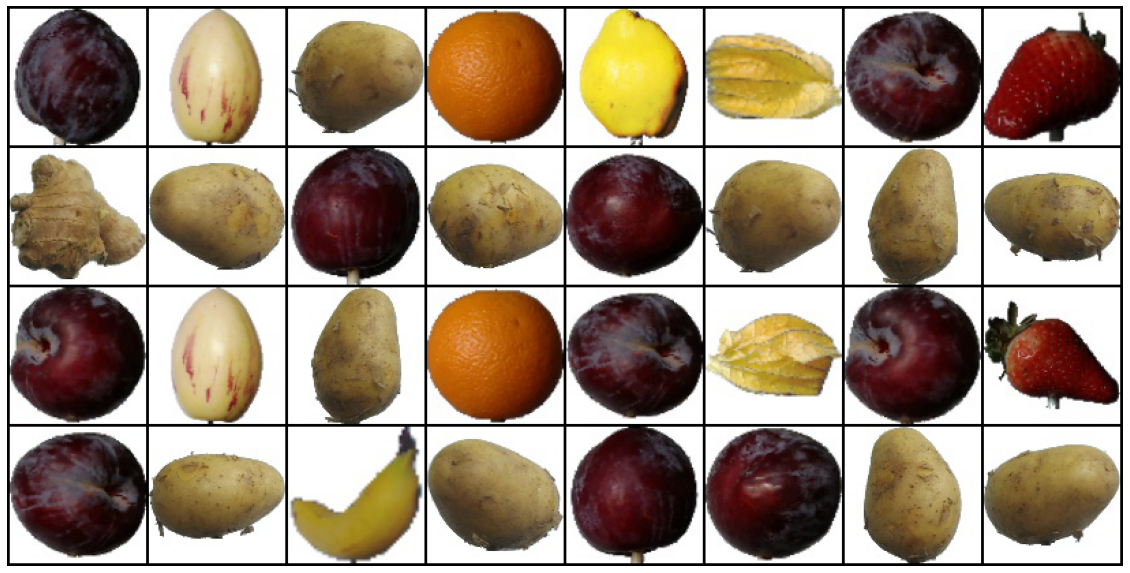

In [29]:
concatenated = torch.cat((example_batch[0][:16], example_batch[1][:16]),0)
show_img(torchvision.utils.make_grid(concatenated), save_into='./fruits/datasets_images.png')

#### Creación de las dataloader

Tras muchas pruebas con las célculas, el color multiplica el tiempo de entrenamiento y no aporta más información que B/N con luminance

In [30]:
siamese_datasets = SiameseDataset(datasets=datasets, transform=transform, should_invert=False, set_luminance=SET_L)
train_loader = DataLoader(siamese_datasets, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)

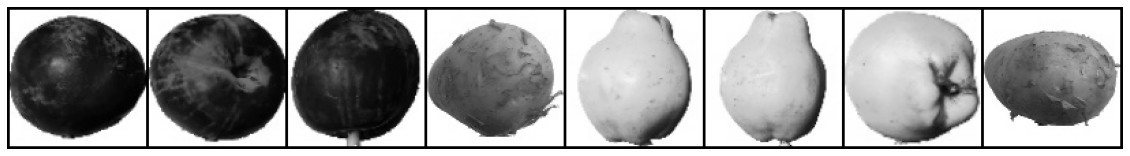

In [31]:
example_batch = next(iter(train_loader))
concatenated = torch.cat((example_batch[0][:4], example_batch[1][:4]),0)
show_img(torchvision.utils.make_grid(concatenated), save_into='./fruits/train_images.png')

#### Creación de la arquitectura [Red Siamesa](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) 

In [32]:
class SiamaseNet(nn.Module):
    
    def __init__(self):
        super(SiamaseNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(INPUT_D, 4, kernel_size=3),
            nn.ReLU(),        
            nn.ZeroPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(),
            nn.ZeroPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 5),
        )
        
    def forward_once(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA)
        resultB = self.forward_once(imageB)
        
        return resultA, resultB

#### Inicialización de la red siamesa

In [33]:
siamese = SiamaseNet().to(device)

####  Función de pérdida [ Contrastive Loss](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf) 

In [34]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, resultA, resultB, label):
        euclidean_distance = F.pairwise_distance(resultA, resultB, keepdim=True) # L2 Norm
        contrastive_loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return contrastive_loss

In [35]:
contrastive_loss = ContrastiveLoss()

#### Definición del opimizado

In [36]:
optimizer = optim.Adam(siamese.parameters(), lr=LR)

## 3.Entrenamiento de la red 

In [37]:
train_loss = 0
train_loss_history = []
N = len(datasets)

for epoch in range(N_EPOCHS):
    for batch_idx, data in enumerate(train_loader):
        imageA, imageB, label = data
        imageA, imageB, label = imageA.to(device), imageB.to(device), label.to(device)
        
        optimizer.zero_grad()
        resultA, resultB = siamese(imageA, imageB)
        loss = contrastive_loss(resultA, resultB, label)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss = train_loss/(N//BATCH_SIZE)
    train_loss_history.append(train_loss)
    print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, train_loss))

    if not os.path.exists('./weights/fruits/'): os.makedirs('./weights/fruits/')
    torch.save(siamese, './weights/fruits/siamese_{:03}.pt'.format(epoch+1))

Train Epoch: 1 Loss: 0.270657
Train Epoch: 2 Loss: 0.082290
Train Epoch: 3 Loss: 0.046114
Train Epoch: 4 Loss: 0.043421
Train Epoch: 5 Loss: 0.024932
Train Epoch: 6 Loss: 0.022114
Train Epoch: 7 Loss: 0.017942
Train Epoch: 8 Loss: 0.029365
Train Epoch: 9 Loss: 0.016129
Train Epoch: 10 Loss: 0.015939
Train Epoch: 11 Loss: 0.013457
Train Epoch: 12 Loss: 0.012783
Train Epoch: 13 Loss: 0.009410
Train Epoch: 14 Loss: 0.009569
Train Epoch: 15 Loss: 0.009930
Train Epoch: 16 Loss: 0.008199
Train Epoch: 17 Loss: 0.006487
Train Epoch: 18 Loss: 0.005821
Train Epoch: 19 Loss: 0.006321
Train Epoch: 20 Loss: 0.006972
Train Epoch: 21 Loss: 0.007035
Train Epoch: 22 Loss: 0.008721
Train Epoch: 23 Loss: 0.005320
Train Epoch: 24 Loss: 0.007645
Train Epoch: 25 Loss: 0.010064
Train Epoch: 26 Loss: 0.007076
Train Epoch: 27 Loss: 0.003685
Train Epoch: 28 Loss: 0.005577
Train Epoch: 29 Loss: 0.005169
Train Epoch: 30 Loss: 0.007226
Train Epoch: 31 Loss: 0.003262
Train Epoch: 32 Loss: 0.005173
Train Epoch: 33 L

## 4.Evaluación de la red

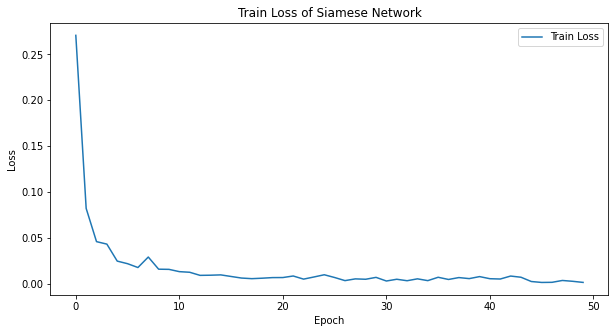

In [38]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Siamese Network")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./Cells/fruits/'): os.makedirs('./Cells/fruits/')
plt.savefig('./Cells/final_train_loss.png')
plt.show()

In [41]:
class_list = os.listdir('./fruits/Test/')
class_list.sort()

datasets = torchvision.datasets.ImageFolder(root=TEST_DIR)
siamese_datasets = SiameseDataset(datasets=datasets, train=False, transform=transform, 
                                  should_invert=False, set_luminance=SET_L)

In [43]:


test_loader = DataLoader(siamese_datasets, num_workers=0, batch_size=1, shuffle=True
                         )
data_iter = iter(test_loader)
imageA, pathA, classA, _, _, _ = next(data_iter)

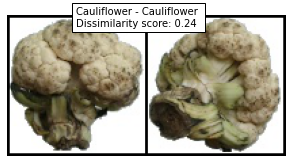

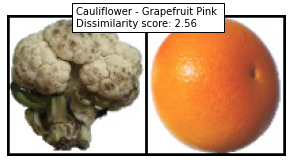

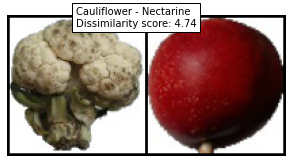

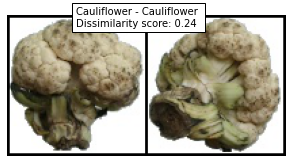

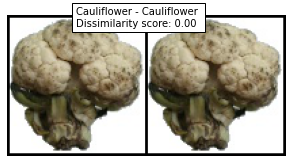

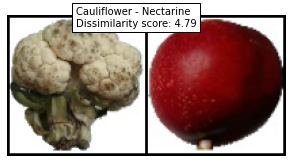

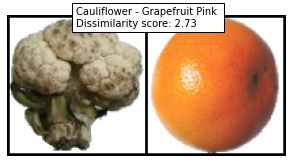

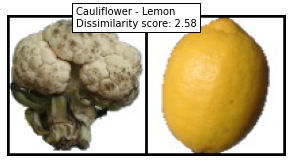

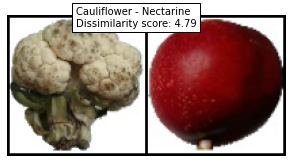

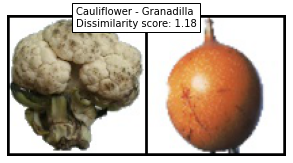

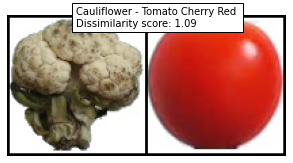

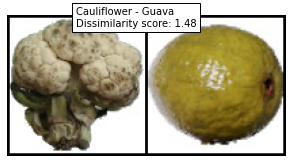

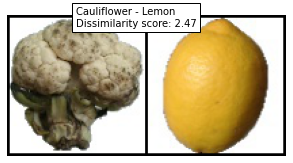

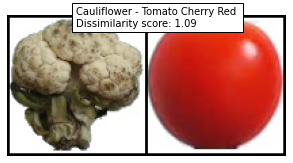

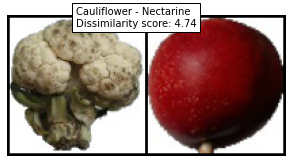

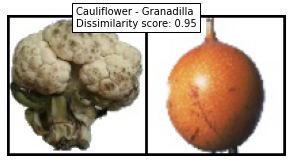

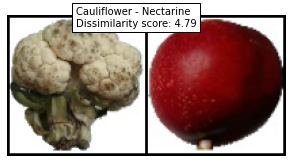

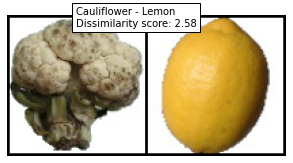

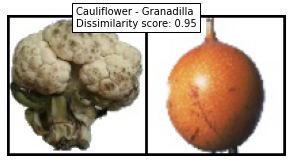

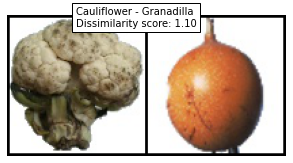

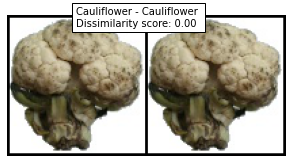

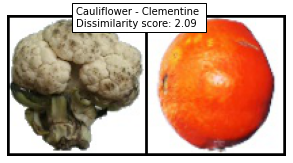

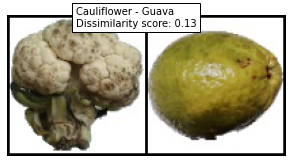

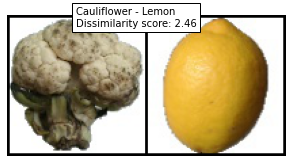

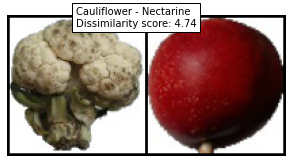

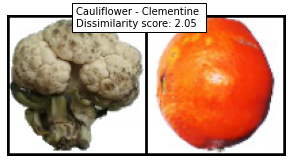

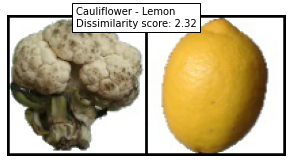

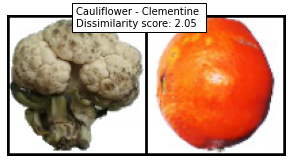

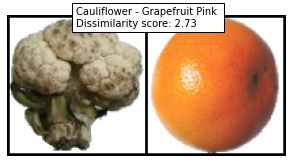

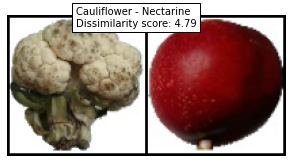

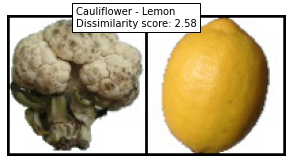

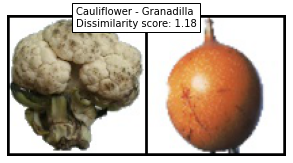

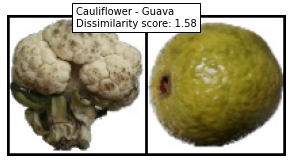

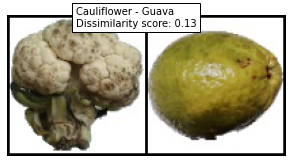

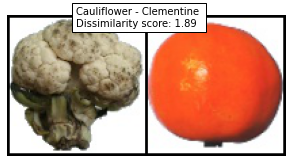

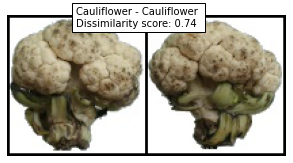

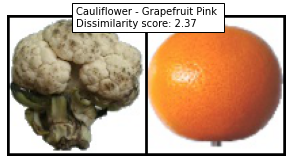

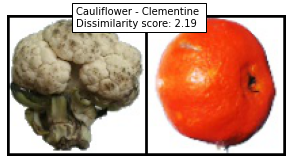

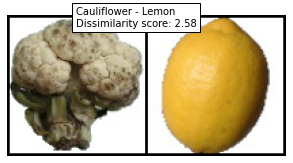

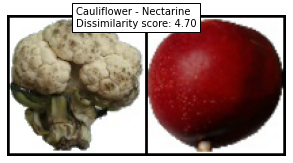

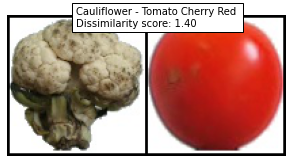

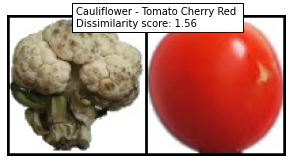

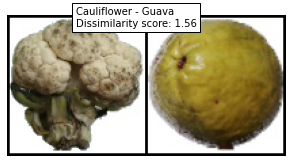

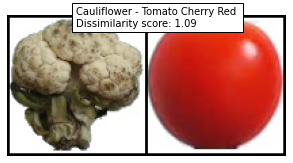

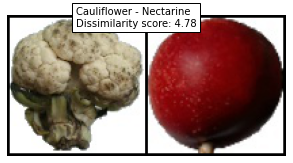

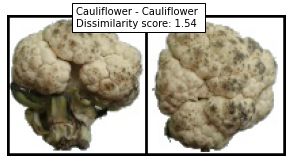

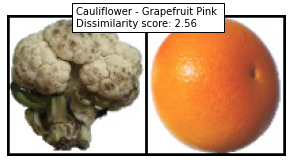

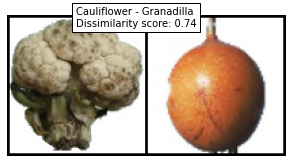

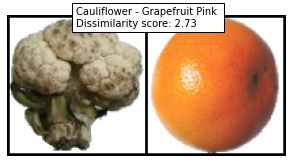

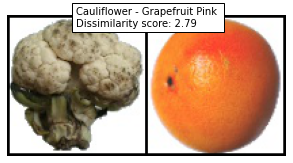

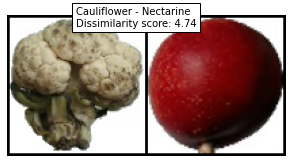

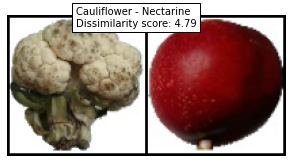

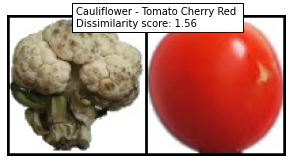

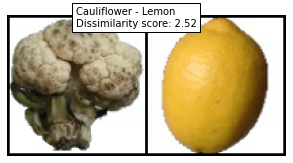

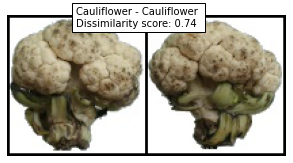

In [44]:
test_loader = DataLoader(siamese_datasets, num_workers=0, batch_size=1, shuffle=True)
data_iter = iter(test_loader)
for i in range(len(datasets)):
    _, _, _, imageB, pathB, classB = next(data_iter)
    
    with torch.no_grad():
        resultA, resultB = siamese(Variable(imageA).to(device), Variable(imageB).to(device))
        euclidean_distance = F.pairwise_distance(resultA, resultB)
    
    # recolour input images
    imageA_ = np.expand_dims(np.transpose(np.array(Image.open(pathA[0])), (2, 0, 1)), axis=0)
    imageA_ = torch.tensor(imageA_)
    imageB_ = np.expand_dims(np.transpose(np.array(Image.open(pathB[0])), (2, 0, 1)), axis=0)
    imageB_ = torch.tensor(imageB_)
    
    concatenated = torch.cat((imageA_, imageB_),0)
    show_img(torchvision.utils.make_grid(concatenated), '{} - {} \nDissimilarity score: {:.2f}'.format(class_list[classA.item()], 
                                                                                                       class_list[classB.item()], euclidean_distance.item()), figsize=(5,5))

---

In [45]:
import pandas as pd
salida = pd.DataFrame ( columns = ['Clase1','Clase2','Distancia'])

test_loader = DataLoader(siamese_datasets, num_workers=0, batch_size=1, shuffle=True)
data_iter = iter(test_loader)
for i in range(len(datasets)):
    _, _, _, imageB, pathB, classB = next(data_iter)
    
    with torch.no_grad():
        resultA, resultB = siamese(Variable(imageA).to(device), Variable(imageB).to(device))
        euclidean_distance = float(F.pairwise_distance(resultA, resultB))
        new_row={'Clase1':class_list[classA.item()],'Clase2':class_list[classB.item()],'Distancia':euclidean_distance}
        salida=salida.append(new_row, ignore_index=True)
        
        #counter=counter+1
        #if  (euclidean_distance <1 & (class_list[classA.item()]==class_list[classB.item()]) | (euclidean_distance >=1 & (class_list[classA.item()]!=class_list[classB.item()])) ):
        # correct=correct+1
        



    # recolour input images
 #   imageA_ = np.expand_dims(np.transpose(np.array(Image.open(pathA[0])), (2, 0, 1)), axis=0)
 #   imageA_ = torch.tensor(imageA_)
 #   imageB_ = np.expand_dims(np.transpose(np.array(Image.open(pathB[0])), (2, 0, 1)), axis=0)
 #   imageB_ = torch.tensor(imageB_)
    
    concatenated = torch.cat((imageA_, imageB_),0)


Trás múltiples pruebas el umbral genérico que mejor funciona con la red siamesa es 1.0.

In [46]:
salida['PRED_OK']=0
salida['Misma_clase']=salida['Clase1'] == salida['Clase2']
salida.loc[((salida['Misma_clase'] ==True) & (salida['Distancia']<1.0)), 'PRED_OK'] = 1
salida.loc[((salida['Misma_clase'] ==False) & (salida['Distancia']>=1.0)), 'PRED_OK'] = 1

#salida.loc[((salida['Clase1'] == salida['Clase2'])& (salida['Distancia'])<1), 'PRED_OK'] = 1
#salida.loc[((salida['Clase1'] != salida['Clase2'])& (salida['Distancia'])>=1), 'PRED_OK'] = 1


#### Acurracy del modelo
Calculamos accuracy del modelo con el umbral seleccionado.

In [47]:
#Acurracy - Dependiendo la ejecución puede variar entre un 65 y un 85%. 

round(sum(salida['PRED_OK']) / salida['PRED_OK'].count()*100,2)

85.45

In [48]:
salida['PRED_OK']=0
salida['Misma_clase']=salida['Clase1'] == salida['Clase2']
salida.loc[((salida['Misma_clase'] ==True) & (salida['Distancia']<0.5)), 'PRED_OK'] = 1
salida.loc[((salida['Misma_clase'] ==False) & (salida['Distancia']>=0.5)), 'PRED_OK'] = 1

#salida.loc[((salida['Clase1'] == salida['Clase2'])& (salida['Distancia'])<1), 'PRED_OK'] = 1
#salida.loc[((salida['Clase1'] != salida['Clase2'])& (salida['Distancia'])>=1), 'PRED_OK'] = 1

print( "0.5")
print(round(sum(salida['PRED_OK']) / salida['PRED_OK'].count()*100,2))




salida['PRED_OK']=0
salida['Misma_clase']=salida['Clase1'] == salida['Clase2']
salida.loc[((salida['Misma_clase'] ==True) & (salida['Distancia']<0.75)), 'PRED_OK'] = 1
salida.loc[((salida['Misma_clase'] ==False) & (salida['Distancia']>=0.75)), 'PRED_OK'] = 1

#salida.loc[((salida['Clase1'] == salida['Clase2'])& (salida['Distancia'])<1), 'PRED_OK'] = 1
#salida.loc[((salida['Clase1'] != salida['Clase2'])& (salida['Distancia'])>=1), 'PRED_OK'] = 1

print( "0.75")
print(round(sum(salida['PRED_OK']) / salida['PRED_OK'].count()*100,2))



salida['PRED_OK']=0
salida['Misma_clase']=salida['Clase1'] == salida['Clase2']
salida.loc[((salida['Misma_clase'] ==True) & (salida['Distancia']<1.25)), 'PRED_OK'] = 1
salida.loc[((salida['Misma_clase'] ==False) & (salida['Distancia']>=1.25)), 'PRED_OK'] = 1

#salida.loc[((salida['Clase1'] == salida['Clase2'])& (salida['Distancia'])<1), 'PRED_OK'] = 1
#salida.loc[((salida['Clase1'] != salida['Clase2'])& (salida['Distancia'])>=1), 'PRED_OK'] = 1

print( "1.25")
print(round(sum(salida['PRED_OK']) / salida['PRED_OK'].count()*100,2))



salida['PRED_OK']=0
salida['Misma_clase']=salida['Clase1'] == salida['Clase2']
salida.loc[((salida['Misma_clase'] ==True) & (salida['Distancia']<1.5)), 'PRED_OK'] = 1
salida.loc[((salida['Misma_clase'] ==False) & (salida['Distancia']>=1.5)), 'PRED_OK'] = 1

#salida.loc[((salida['Clase1'] == salida['Clase2'])& (salida['Distancia'])<1), 'PRED_OK'] = 1
#salida.loc[((salida['Clase1'] != salida['Clase2'])& (salida['Distancia'])>=1), 'PRED_OK'] = 1

print( "1.5")
print(round(sum(salida['PRED_OK']) / salida['PRED_OK'].count()*100,2))


salida['PRED_OK']=0
salida['Misma_clase']=salida['Clase1'] == salida['Clase2']
salida.loc[((salida['Misma_clase'] ==True) & (salida['Distancia']<1.75)), 'PRED_OK'] = 1
salida.loc[((salida['Misma_clase'] ==False) & (salida['Distancia']>=1.75)), 'PRED_OK'] = 1

#salida.loc[((salida['Clase1'] == salida['Clase2'])& (salida['Distancia'])<1), 'PRED_OK'] = 1
#salida.loc[((salida['Clase1'] != salida['Clase2'])& (salida['Distancia'])>=1), 'PRED_OK'] = 1
print( "1.75")
print(round(sum(salida['PRED_OK']) / salida['PRED_OK'].count()*100,2))




0.5
90.91
0.75
90.91
1.25
72.73
1.5
63.64
1.75
56.36
